this code does everything in memory of 12.7 GB in 14 min it crashes so use the other file finalthesiscode/MakeMyDataset to create and move the hole dataset in storage.

> Or use generator to steam the data



In [ ]:
import os
import random
import pathlib
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import uuid
import cv2
import os
import shutil
import albumentations as A
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# root= '/content/drive/MyDrive/ColabNotebooks/Datas/plantvillage-dataset/color/'



### Parsing of the path and creating the DataFrame

# Function __parse_root__ includes

  *   Fuction ***extract_plant_names*** seperates the Folder string names      into 2 new Series based on a **regex** pattern:

    *   Plants
    *   Sudirectory Names: Disease or Healty

  * Function __clasify_folders__ that classifies folder depended on the mean value:
    *   Above mean
    *   Below mean
    *   Risk

  * Function __meta_data__ responsible of updating a dataframe based on metrics and will include:
    * Split amount for the different splits
    * Total Files that remain after the split
    * Augmented images we need to reach the value we want
    * How many original images we need to augment




  > The __Inputs__ are :
  * root path,
  * regex pattern,
  * a list with labels to be removed.

  > The __Output__ will be:
  * A dataframe that includes statistics and info to guide processes
  * A dictionary with label names as keys and paths as values









In [ ]:
def extract_plant_names(folder_names, pattern):
    """
    Extract plant names from folder names using a regex pattern.
    Alerts for any unmatched folder names.

    Parameters:
        folder_names (list): List of folder names to process.
        pattern (str): Regex pattern to extract plant names.

    Returns:
        plant_names (list): List of extracted plant names.
        sub_names (list): List of the folder names with out the plant string.
    """
    plant_names = []
    unmatched = []
    sd_names = []

    for folder in folder_names:
        match = re.match(pattern, folder)
        if match:
            plant_name = match.group(1)
            sd_name = folder.split("___")[1]  # Assuming "___" separates the plant and the second name
            plant_names.append(plant_name)
            sd_names.append(sd_name)
        else:
            plant_names.append("Unknown")
            sd_names.append("Unknown")
            unmatched.append(plant_names)

    # Alert for unmatched folder names
    if unmatched:
        print("⚠️ Alert: The following folder names did not match the expected pattern:")
        for folder in unmatched:
            print(f"- {folder}")

    return plant_names,sd_names

In [ ]:
def classify_folders(counts):
    """
    Categorizes numerical counts into:
      - 'Above_mean' (counts => mean)
      - 'Below_mean' (half_mean ≤ counts ≤ mean)
      - 'Risk' (counts < half_mean)

    Returns a NumPy array of category labels.
    """
    mean_value = int(counts.mean())
    half_mean = mean_value // 2  # Ensure integer division consistency


    print(f"Mean: {mean_value}, Half Mean: {half_mean}")

    return np.select(
        [counts >= mean_value, counts >= half_mean],
        ["Above_mean", "Below_mean"],
        default="Risk"
    )


In [ ]:
def meta_data(folder_counts):
  mean_value = int(folder_counts["Counts"].mean())

  # Anything that is" not in Risk will have 100 items the rest will be 200 items for validation and test
  folder_counts["split_size"] = np.where(folder_counts["MeanCategory"] != "Risk", 200, 100)

  # Compute the number of images available for training after the split
  folder_counts["train_files"] = folder_counts["Counts"] - (folder_counts["split_size"]*2)
  # we cut down the Above_mean category
  folder_counts.loc[folder_counts["MeanCategory"] == "Above_mean", "train_files"] = mean_value // 2

  # Compute the number of images that we need to compensate with augmentation
  folder_counts["Augment_Needed"] = np.maximum(0, mean_value - folder_counts["train_files"])

  # Compute the number of distinct images required for augmentation (rounded up)
  folder_counts["original_files"] = np.ceil(folder_counts["Augment_Needed"] / 15).astype(int)
  return folder_counts

In [ ]:
def parse_root(root,pattern = r'^([^_]+)',remove=None):
    """Parse dataset folder structure and build a dataframe with metadata."""


    p = pathlib.Path(root)
    dist_files = {
        folder.name: [file for file in folder.iterdir()]
        for folder in p.iterdir() if folder.is_dir()
    }
    # Count files in each folder
    folder_counts = pd.DataFrame({
        'Folder': dist_files.keys(),
        'Counts': [len(v) for v in dist_files.values()]
    })

    if remove is None:
      remove=['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus',
        'Apple___Cedar_Rust','Tomato___Tomato_mosaic_virus','Potato___Early_blight','Potato___Late_blight','Potato___healthy']
      folder_counts.drop(folder_counts[folder_counts['Folder'].isin(remove)].index,inplace=True)
    # fldoer_counts = folder_counts.drop(columns=[key for key in remove if key in folder_counts])
      folder_counts.reset_index(drop=True, inplace=True)

    folder_counts['Plants'], folder_counts['Sub'] = extract_plant_names(folder_counts['Folder'],pattern)
    folder_counts['MeanCategory'] = classify_folders(folder_counts['Counts'])
    folder_counts = meta_data(folder_counts)

    return folder_counts, dist_files

# Function __distribute_data__ responsible of :

Distributing the data with the guidness of a dataframe into 4 splits:
* Train
* Test
* Validation
* Augmentation

In [ ]:
def distribute_data(df, dist_files):

  """" Creates splits of train,validation and iamge file paths and take some to be augmented.
      Based on the metadata we transform the split strategy and provide sets of files to be used.

  """

  train, validation, test, aug_train = {}, {}, {}, {}
  for _, row in df.iterrows():
    folder = row["Folder"]
    available_files = dist_files.get(folder, []).copy()

    # Shuffle to ensure randomness
    random.shuffle(available_files)

    # Extract necessary values
    split_size = row["split_size"]  # Now dynamically assigned per category
    distinct_aug_sources = int(row["original_files"])  # Available distinct images
    # For each key : Folder Name

    # 1) Allocate test set
    test[folder], available_files = available_files[:split_size], available_files[split_size:]

    # 2) Allocate validation set
    validation[folder], available_files = available_files[:split_size], available_files[split_size:]

    # 3) Reserve originals for augmentation (only if augment=True)
    aug_train[folder], available_files = available_files[:distinct_aug_sources], available_files[distinct_aug_sources:]

    train[folder] = available_files

  return train, validation, test, aug_train


# Definition of Augmentation function

As Input has:
* Image paths
* Amount of loops

As Outputs:
* List  of Augmented  images + the original

> Take an image path and process it through 3 different augmentations __multiplied__ by loops .

> __One image will be passed through 3 augmentations for 5 times. Thus will provide 15 new images + 1 original = 16 images.__

The function can be changed by the user or to select another one through the function __build_dataset__ below.

In [ ]:

weather = A.Compose([
     A.RandomSnow(brightness_coeff=1.7,  snow_point_range= (0.3,0.5),p=0.5),
     A.RandomRain(brightness_coefficient=0.8, drop_width=2, blur_value=3, p=0.5)
 ])

light = A.Compose([
    # A. RandomBrightnessContrast(brightness_limit=(-0.23,0.35),p=0.5),
    A.GridDropout(ratio=0.3,p=0.5),
    A.MultiplicativeNoise(multiplier=(0.97,2.30),elementwise=True,per_channel=True,p=0.5)
])

geometric = A.Compose([
     A.CLAHE(p=1),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5)

])

def Aug(img_path,loops):
    """
    Load one image with Keras, then produce 16 images:
      1 original + 15 augmented (5 loops × 3 pipelines).
    Each returned image is np.uint8 in [0..255].
    Shape is consistent with the original loaded image.
    """
    pil_img = tf.keras.utils.load_img(img_path, color_mode='rgb')
    base_arr = np.array(pil_img, dtype=np.uint8)

    aug_list = [base_arr]  # keep original
    sshape = base_arr.shape  # (H, W, 3)

    for _ in range(loops):
        w = weather(image=base_arr)['image']
        l = light(image=base_arr)['image']
        g = geometric(image=base_arr)['image']
        for arr in [w, l, g]:
            if arr.shape != sshape:
                arr = np.resize(arr, sshape)
            aug_list.append(arr)

    return aug_list


# Function __build_dataset__ responsible to:
Deliver Tensorflow datasets in the right format and shapeready to be process by tensorflow models. Furthermore instead of writing the new images on drive, stream in RAM the dataset in order to process on spot the hole dataset.

* Function __parse_record__:  
  * Reads & decodes image to unit8 3 channels
  * Convert to float, fix the shape and __resize__ if applicable

* Function __flatten_dict__:
  * Parallel lists of Paths and Labels  for Tuples of (Path,label)

* Function __gen__:
  * This is the generator responsible of streaming process
  and augmenting.
  * here user can use their own __augmentation__ proccess instead of *Aug*

* Function __scale_unit8__:
  * Scales unit8 augmented images to float 32
  * Keeps the corrrect shape

In [ ]:
def build_dataset_from_dict(
    data_dict,
    target_size= None,
    to_augment= None,
    loops= 5) -> tf.data.Dataset:


    def parse_record(file_path, label_str):
        """
        - file_path: tf.string path to the image file
        - label_str: tf.string label
        """
        # Read file from disk
        image_bytes = tf.io.read_file(file_path)

        # Decode image (handles PNG, JPEG, etc.), expand_animations=False ensures a single image
        img = tf.io.decode_image(image_bytes, channels=3)
        # Now img has shape [height, width, 3], dtype=uint8 in [0..255]

        # Convert to float [0..1], then resize
        img = tf.image.convert_image_dtype(img, tf.float32)
        img.set_shape([None, None, 3])
        if target_size is not None:
          img = tf.image.resize(img, target_size)  # (H, W, 3)
        return img, label_str


     #  make (file_path, label)  Flatten dict -> (files, labels)
    def flatten_dict(d):
        # Create two parallel lists
        file_paths = []
        labels = []
        for lbl, paths in d.items():
            for p in paths:
                file_paths.append(str(p))
                labels.append(lbl)
        return file_paths, labels

    normal_files, normal_labels = flatten_dict(data_dict)
    # 2) Create dataset from these records and process it
    ds = tf.data.Dataset.from_tensor_slices((normal_files,normal_labels))
    ds = ds.map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)

    if not to_augment:
        return ds

    # -- streaming generator for AUGMENTED images -------------
    def gen():
        for lbl, paths in to_augment.items():
            for p in paths:
                for arr in Aug(p, loops=loops):
                    yield arr, lbl

    ds_aug = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(),              dtype=tf.string),
        ))


    # scale uint8→float32, resize
    def scale_uint8(img_u8, label):
        img = tf.image.convert_image_dtype(img_u8, tf.float32)
        img.set_shape([None, None, 3])
        label = tf.cast(label, tf.string)
        if target_size is not None:
          img = tf.image.resize(img, target_size)  # (H, W, 3)
        return img, label

    ds_aug = ds_aug.map(scale_uint8, num_parallel_calls=tf.data.AUTOTUNE)

    # -- merge & return --------------------------------------
    ds_final=ds.concatenate(ds_aug)
    return ds_final



# Function in case of __store in drive__:
Call the function 3 times for each split

In [ ]:
def process_images(dataset_dict, base_path, dataset_type, augment=None):
    for folder_name, image_paths in dataset_dict.items():
      # Take each folder_name and check if we have a folder
      folder_path = os.path.join(base_path, dataset_type, folder_name)
      os.makedirs(folder_path, exist_ok=True)
      # Take any image path of each folder_name and copy paste
      for image_path in image_paths:
          dest_path = os.path.join(folder_path, os.path.basename(image_path))
          shutil.copy(image_path, dest_path)

    if augment is not None:
      for k,v in augment.items():
        folder_path = os.path.join(base_path, dataset_type, k)
        for img_path in v:
          aug_list = Augs(img_path)
          for aug_img in aug_list:
              filename = os.path.join(folder_path, f"{uuid.uuid4().hex[:10]}.jpg")
              cv2.imwrite(filename, aug_img)

# Function __Describe_Models__ responsible to:
Receives a list of models. Unpack each model and store the data of each layer.
Stored info is a __dataframe__ of:
  * Model name
  * Layer name
  * Score (value of the layer)
  * Label (which is th numerical count of eeach model layer)

In [ ]:
import os
import re
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import model_from_json

def describe_model(models):
    """
    Recursively gather layers info from a final model, *but*:
      - For the base model (like MobileNetV2), retrieve the base model name as a string in a separate column.
        (No expansion of base layers)
      - For the 'head' model (e.g., a Sequential), skip the top-level name, but store each sub-layer
        (Dense/Dropout, etc.).

    Returns a list of tuples: (model_label, layer_name, attribute_value, base_model_string).
    """

    if isinstance(models, tf.keras.Model):
        models = [models]

    all_info = []

    def store_info(label, layer_obj, base_model_str=None):
        """
        Extract attribute from layer_obj (units, filters, rate) if present.
        Return a tuple (label, layer_name, attr_val, base_model_str).
        """
        if hasattr(layer_obj, 'units'):
            attr_val = layer_obj.units
        elif hasattr(layer_obj, 'filters'):
            attr_val = layer_obj.filters
        elif hasattr(layer_obj, 'rate'):
            attr_val = layer_obj.rate
        else:
            attr_val = None

        return (label, layer_obj.name, attr_val, base_model_str)

    def is_base_model(layer):
        """
        Heuristic check: if layer is a Keras Model and it's one of the known
        pretrained application names or typically has 'mobilenetv2', 'resnet50', etc. in the name,
        we treat it as the 'base model.'
        """
        if isinstance(layer, tf.keras.Model):
            if any(k.lower() in layer.name.lower() for k in ["mobilenetv2", "resnet50"]):
                return True
        return False

    def expand_layers(layer_list, parent_label="", base_model_str=None):
        """
        For each layer in layer_list:
          - If it's the 'base model', remember its name for all following layers.
          - If it's a sub-model (not base), expand it recursively.
          - Otherwise, store the layer info including base_model_str.
        """
        for layer in layer_list:
            if is_base_model(layer):
                base_model_str = layer.name
            elif isinstance(layer, tf.keras.Model):
                expand_layers(layer.layers, parent_label=parent_label, base_model_str=base_model_str)
            else:
                info = store_info(parent_label, layer, base_model_str)
                all_info.append(info)

    for model_obj in models:
        expand_layers(model_obj.layers, parent_label=model_obj.name)

    return layer_info_to_df(all_info)


def layer_info_to_df(layer_info):
    """
    layer_info : list of tuples [(model_label, layer_name, attr_val, base_model_string), ...]
    Returns a DataFrame with columns: [model name, layer name, score, base model]
    """
    df = pd.DataFrame(layer_info, columns=["model name", "layer name", "score", "base model"])

    # Clean trailing digits from layer names (optional)
    df['layer name']=df['layer name'].apply(lambda x: re.sub(r'_.*', '', x))

    # Generate unique label where layer name is not null

    df['label'] = (
        df.groupby(['model name', 'layer name'])
        .cumcount()
        .astype(str)
        .radd(df['layer name'] + '_'))

    df.dropna(inplace=True)

    return df


# Instantiate Builder a
# Recursively collect all layer info (including nested sub-models) and convert it into a dataframe
# df = describe(models)
# df


In [ ]:
# df,actual=parse_root(root)
# print(df.head())
# train,val,test,aug=distribute_data(df, actual)


# print(f"Train size: {len(train)} and {sum(len(v) for v in train.values())}")
# print(f"Augmented: {len(aug)} and {sum(len(v) for v in aug.values())}")
# print(f"Validation size: {len(val)} and {sum(len(v) for v in val.values())}")
# print(f"Test size: {len(test)} and {sum(len(v) for v in test.values())}")

# for k,v in aug.items():
#   print(k,len(v))


Mean: 1205, Half Mean: 602
                                     Folder  Counts  Plants  \
0  Cherry_(including_sour)___Powdery_mildew    1052  Cherry   
1               Corn_(maize)___Common_rust_    1192    Corn   
2       Corn_(maize)___Northern_Leaf_Blight     985    Corn   
3                    Corn_(maize)___healthy    1162    Corn   
4                         Grape___Black_rot    1180   Grape   

                    Sub MeanCategory  split_size  train_files  Augment_Needed  \
0        Powdery_mildew   Below_mean         200          652             553   
1          Common_rust_   Below_mean         200          792             413   
2  Northern_Leaf_Blight   Below_mean         200          585             620   
3               healthy   Below_mean         200          762             443   
4             Black_rot   Below_mean         200          780             425   

   original_files  
0              37  
1              28  
2              42  
3              30  
4      

In [ ]:
# limited_train = {key: value[:3] for key, value in train.items()}
# limited_aug= {key: value[:3] for key, value in aug.items()}
# final_train=build_dataset_from_dict(data_dict=limited_train,to_augment=limited_aug)
# print("Element spec:", final_train.element_spec)

# for imgs, lbls in final_train.take(1):
#     print("Batch image tensor shape:", imgs.shape)   # (batch, 224, 224, 3)
#     print("Batch labels:", lbls.numpy())


# n=df["Folder"].to_list()

# string_lookup = tf.keras.layers.StringLookup(
#                     vocabulary      = n,
#                     output_mode     = "one_hot",
#                     num_oov_indices = 0)

# final_train= final_train.map(
#     lambda img, lbl: (
#         img,
#         tf.squeeze(                      # remove length‑1 middle axis
#             tf.cast(string_lookup(lbl), tf.float32),
#             axis=-2                      # or axis=1 (same thing here)
#         )
#     ),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

# BATCH = 5
# final_train = (final_train
#                   .shuffle(1024)
#                   .batch(BATCH)
#                   .prefetch(tf.data.AUTOTUNE))

# for i,y in final_train.take(1):
#   print(y)

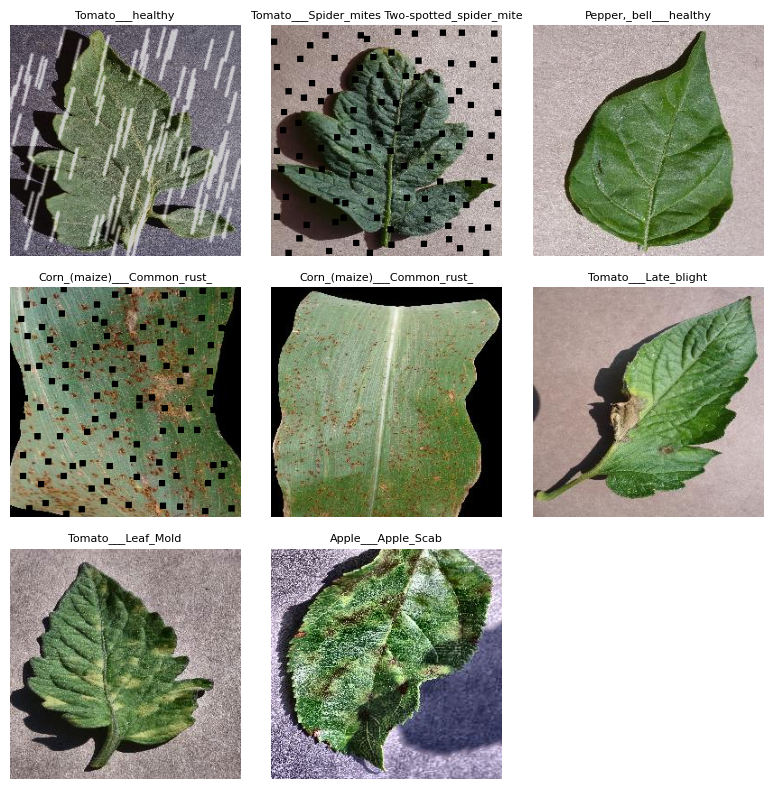

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from math import ceil

# def show_samples(ds, max_images=8, figsize=(8, 8)):
#     """
#     Show up to 8 images from a tf.data.Dataset that yields
#     (image_tensor, label) — works for batched or unbatched datasets.
#     Labels are printed as raw values under each image.
#     """
#     imgs, lbls = [], []

#     for img, lbl in ds.take(max_images):
#         # split batch if necessary
#         if img.shape.ndims == 4:              # batched
#             for i in range(img.shape[0]):
#                 imgs.append(img[i])
#                 lbls.append(lbl[i])
#                 if len(imgs) >= max_images:
#                     break
#         else:                                 # single image
#             imgs.append(img)
#             lbls.append(lbl)
#         if len(imgs) >= max_images:
#             break

#     n     = len(imgs)
#     cols  = int(ceil(np.sqrt(n)))
#     rows  = int(ceil(n / cols))

#     plt.figure(figsize=figsize)
#     for i, (im, lab) in enumerate(zip(imgs, lbls), 1):
#         ax = plt.subplot(rows, cols, i)
#         plt.imshow(im)
#         # raw label → string for title
#         if lab.shape.ndims == 0:            # scalar
#             title = lab.numpy().decode() if lab.dtype == tf.string else str(lab.numpy())
#         elif lab.shape.ndims == 1:          # one-hot
#             title = str(int(tf.argmax(lab).numpy()))
#         else:
#             title = "?"
#         plt.title(title, fontsize=8)
#         plt.axis("off")
#     plt.tight_layout()
#     plt.show()
# show_samples(final_train.shuffle(buffer_size=10000))